In [1]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import time
from boruta import boruta_py
import numpy as np
from sklearn.model_selection import cross_val_score
import winsound
import matplotlib.pyplot  as plt

In [2]:
settings = {
                "dataset":"data_after_cleaning.csv",
                "columns_dataset": "scores_after_multicol.csv",
                "wrapper_tech": {
                        'rfc':{},
                        'ga':{},
                        'Boruta':{
                            "n_estimators":'auto',
                            "verbose":2
                            },
                        'xgboost':{}
                },
                "models":
                    {
                        'svm':
                             {
                                  'kernel':"linear"
                             },
                        'rf':
                             {
                                     'random_state':101,
                                     'max_depth':10
                             }
                    },
                "scoring_type":'neg_mean_absolute_error',
                "cross_val_times":2,
                "datapoints":500, #fill in all if you want to use all datapoints,
                "allow_creating_new_results_df":True, #only allow making new results df when True (risky to keep on true after testing)
                "threshold_xgboost": 0.1#0.006535948

}

In [ ]:
data = pd.read_csv('data/' + settings["dataset"])


# columns = [column for column in pd.read_csv('data/'+settings["columns_dataset"])["features"].values if column != 'Intercept']

columns = list(data.columns)
columns.append("close_price_next_min") 
final_columns = [column for column in columns if column!="close_price_next_min"]
X = data[final_columns].values
y = data["close_price_next_min"].values

In [ ]:
#reduce dataset if needed
if settings['datapoints'] is not 'all':
    X = X[:settings['datapoints']]
    y = y[:settings['datapoints']]
        

In [ ]:
len(list(data.columns))

<h1> Baseline

In [ ]:
for type_model in settings['models'].keys():
        t1 = time.time()
        if 'svm' ==type_model:
            model = SVR(**settings['models']['svm'])
        elif 'rf' ==type_model:
            model = RandomForestRegressor(**settings['models']['rf'])
        score =  np.mean(-1*cross_val_score(model,
                                           X,
                                           y,
                                           cv=settings['cross_val_times'],
                                           scoring=settings['scoring_type']))
        
        print(f'score before {type_model} is {score}')
        print(f'Running time is {time.time() - t1}')
        print('----------')

<h1> Helper funct

In [ ]:
class Datahandling():
    def __init__(self,name_dataframe):
        self.name_dataframe = name_dataframe
        self.columns = ['iteration','wrapper','optimal_number_of_features','score_optimal_features','scoring_type',
                                            'cross_val_times','datapoints','params','running_time']
        try:
            self.current_df = pd.read_csv('results/'+name_dataframe)
            self.highest_iteration = max(self.current_df['iteration'].values)
        except Exception as e:
            #print(f"Error {e} occured")
            print('New dataframe will be made')
            if not settings["allow_creating_new_results_df"]:
                if not input("Type YES if this is oke") == "YES": 
                    raise TypeError("User decided to cancel process, so canceling. Program will crash bc no highest iter and df")
                else: #not pretty to have 2 times same else, but very tired at the moment
                    self.current_df = pd.DataFrame(columns=self.columns)
                    self.highest_iteration = 0
            
            else:
                self.current_df = pd.DataFrame(columns=self.columns)
                self.highest_iteration = 0
            
    def save_after_iter(self,final_model):
        final_model.to_csv('results/'+self.name_dataframe,index=False)
        
        
        
            
        
        
                                       
        


<h1> Method 1: RFC

In [ ]:
#def extract_info():
data = Datahandling('scores_rfc_columns.csv')
highest_iter = data.highest_iteration
df_models_scores = data.current_df

df_scores = pd.DataFrame(index=final_columns)
if 'rfc' in settings['wrapper_tech'].keys():
    t1 = time.time()
    for type_model in settings['models'].keys():
        t2 = time.time()
        if 'svm' ==type_model:
            model = SVR(**settings['models']['svm'])
        elif 'rf' ==type_model:
            model = RandomForestRegressor(**settings['models']['rf'])
        
        rfecv = RFECV(estimator=model, scoring=settings["scoring_type"],cv=settings['cross_val_times'])
        rfecv.fit(X, y)            
        scores = {column:{} for column in final_columns}
        for i in range(len(final_columns)):
            scores[final_columns[i]] = {
                f"selected_{type_model}":rfecv.support_[i],
                f"ranking_{type_model}":rfecv.ranking_[i]} #selected features are always 1 
               # "grid_score":rfecv.grid_scores_[i],The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.
                #"estimator":rfecv.estimator_[i]
            
        summary = [{
            'wrapper':type_model,
            'iteration':highest_iter +1,
            'grid_scores': rfecv.grid_scores_,
            'scores':scores,
            'optimal_number_of_features':rfecv.n_features_,
            'score_optimal_features':rfecv.grid_scores_[rfecv.n_features_-1],
            'scoring_type':settings['scoring_type'],
            "cross_val_times":2,
            "datapoints":settings['datapoints'],
            'params':settings['models'][type_model],
            'running_time':time.time() - t2,
            'scores':scores,
            'ranking':rfecv.ranking_
        }
        ]
    
        #df_new = pd.DataFrame.from_dict(scores,orient='index')
        #df_scores = df_scores.merge(df_new,left_index=True,right_index=True)
        df_models_scores = df_models_scores.append(summary,ignore_index=True)
#df_scores.to_csv("data/scores_rfc_columnsvvvvvvvv.csv")
data.save_after_iter(df_models_scores)
#df_models_scores.to_csv("data/scores_rfc_models.csv")
print(f"total running time: {time.time() - t1}")
        
        
    

    

# testing 0.5

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_



In [ ]:
selector.ranking_


# Testing 1

In [ ]:
#def extract_info():
data = Datahandling('scores_rfc_columns.csv')
highest_iter = data.highest_iteration
df_models_scores = data.current_df

df_scores = pd.DataFrame(index=final_columns)
if 'rfc' in settings['wrapper_tech'].keys():
    t1 = time.time()
    for type_model in settings['models'].keys():
        t2 = time.time()
        if 'rf' ==type_model:
            model = RandomForestRegressor(**settings['models']['rf'])
        
        rfecv = RFECV(estimator=model, scoring=settings["scoring_type"],cv=settings['cross_val_times'])
        rfecv.fit(X, y)            
        scores = {column:{} for column in final_columns}
        for i in range(len(final_columns)):
            scores[final_columns[i]] = {
                f"selected_{type_model}":rfecv.support_[i],
                f"ranking_{type_model}":rfecv.ranking_[i]} #selected features are always 1 
               # "grid_score":rfecv.grid_scores_[i],The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.
                #"estimator":rfecv.estimator_[i]
            
        summary = [{
            'wrapper':type_model,
            'iteration':highest_iter +1,
            'grid_scores': rfecv.grid_scores_,
            'scores':scores,
            'optimal_number_of_features':rfecv.n_features_,
            'score_optimal_features':rfecv.grid_scores_[rfecv.n_features_-1],
            'scoring_type':settings['scoring_type'],
            "cross_val_times":2,
            "datapoints":settings['datapoints'],
            'params':settings['models'][type_model],
            'running_time':time.time() - t2,
            'scores':scores,
            'ranking':rfecv.ranking_
        }
        ]
    
        #df_new = pd.DataFrame.from_dict(scores,orient='index')
        #df_scores = df_scores.merge(df_new,left_index=True,right_index=True)
        df_models_scores = df_models_scores.append(summary,ignore_index=True)
#df_scores.to_csv("data/scores_rfc_columnsvvvvvvvv.csv")
data.save_after_iter(df_models_scores)
#df_models_scores.to_csv("data/scores_rfc_models.csv")
print(f"total running time: {time.time() - t1}")
        
        
    

In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [ ]:
X

In [ ]:
dset = pd.DataFrame()
dset['attr'] = data.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [ ]:
winsound.Beep(1000, 3000)

<h1> Method 2: Boruta

In [ ]:
from boruta import boruta_py
df_scores = pd.DataFrame(index=final_columns)
data = Datahandling('scores_boruta_columns.csv')
highest_iter = data.highest_iteration
df_models_scores = data.current_df
if 'Boruta' in settings['wrapper_tech'].keys():
    t1 = time.time()
    type_model = 'rf'

    model = RandomForestRegressor(**settings['models']['rf'])


    borutaPY = boruta_py.BorutaPy(model,
                               n_estimators=settings['wrapper_tech']['Boruta']["n_estimators"],
                               verbose=settings['wrapper_tech']['Boruta']["verbose"])
    
    borutaPY.fit(X, y)     
    score =  np.mean(-1*cross_val_score(model,
                                       X[:,borutaPY.support_],
                                       y,
                                       cv=settings['cross_val_times'],
                                       scoring=settings['scoring_type']))
    scores = {column:{} for column in final_columns}
    for i in range(len(final_columns)):
        scores[final_columns[i]] = {
            f"selected_{type_model}":borutaPY.support_[i],
            f"ranking_{type_model}":borutaPY.ranking_[i], #selected features are always 1 
            f"tentative_{type_model}":borutaPY.support_weak_[i]} #Those for which Boruta could not justify whether they are relevant or not
           # "grid_score":borutaPY.grid_scores_[i],The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.
            #"estimator":borutaPY.estimator_[i]
    
    summary = [{
        'wrapper':type_model,
        'iteration':highest_iter+1,
      #  'grid_scores': borutaPY.grid_scores_,
        'optimal_number_of_features':borutaPY.n_features_,
        'score_optimal_features':score,
        'scores':scores,

        'scoring_type':settings['scoring_type'],
         "cross_val_times":settings['cross_val_times'],
        "datapoints":settings['datapoints'],
        'params':settings['models'][type_model],
        'running_time':time.time() - t1
    }
    ]

    df_models_scores = df_models_scores.append(summary,ignore_index=True)
data.save_after_iter(df_models_scores)
print(f"total running time: {time.time() - t1}")
        
        
    

    

# TESting


In [ ]:
from boruta import boruta_py

model = RandomForestRegressor(n_jobs=-1,  max_depth=10)

borutaPY = boruta_py.BorutaPy(model, n_estimators='auto',verbose=2,random_state=1)
    
borutaPY.fit(X, y)     

borutaPY.ranking_

In [ ]:
# def load_data():
#     # URLS for dataset via UCI
#     train_data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
#     train_label_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'

#     X_data = pd.read_csv(train_data_url, sep=" ", header=None)
#     y_data = pd.read_csv(train_label_url, sep=" ", header=None)
#     data = X_data.loc[:, :499]
#     data['target'] = y_data[0]
#     return data

In [ ]:
# data = load_data()

In [ ]:
data2

In [ ]:
# y = data.pop('target')
# X = data.copy().values


In [ ]:
rf = RandomForestClassifier(n_jobs=-1, class_weight=None, max_depth=7, random_state=0)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)

In [ ]:
feat_selector.fit(X, y)

In [ ]:

# Check selected features
print(feat_selector.support_)
# Select the chosen features from our dataframe.
selected = X[:, feat_selector.support_]


In [ ]:
feat_selector.ranking_

<h1> Method 3: Xgboost
    

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause
from numpy import loadtxt
from xgboost import XGBRegressor 
from xgboost import XGBClassifier 

df_scores = pd.DataFrame(index=final_columns)
data = Datahandling('scores_xgboost_columns.csv')
highest_iter = data.highest_iteration
df_models_scores = data.current_df
if 'xgboost' in settings['wrapper_tech'].keys():
    type_model = 'xgboost'
    t1 = time.time()

    # fit model no training data
    model = XGBClassifier()
    model.fit(X, y)
    scores = {column:{} for column in final_columns}
    for i in range(len(final_columns)):
        scores[final_columns[i]] = {
            f"importance_score_{type_model}":model.feature_importances_[i],
            f"selected_{type_model}":True if model.feature_importances_[i] >= settings["threshold_xgboost"] else False }
            #f"ranking_{type_model}":rfecv.ranking_[i]} #selected features are always 1 
           # "grid_score":rfecv.grid_scores_[i],The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.
            #"estimator":rfecv.estimator_[i]
    score =  np.mean(-1*cross_val_score(model,
                                   X[:,[scores[column][f"selected_{type_model}"] for column in final_columns]],
                                   y,
                                   cv=settings['cross_val_times'],
                                   scoring=settings['scoring_type']))
    summary = [{
        'wrapper':type_model,
        'iteration':highest_iter +1,
        #'grid_scores': rfecv.grid_scores_,
        'optimal_number_of_features':len([scores[column][f"selected_{type_model}"] for column in final_columns if scores[column][f"selected_{type_model}"]]), #only true
        'scores':scores,
        'score_optimal_features':score,
        'scoring_type':settings['scoring_type'],
        "cross_val_times":settings['cross_val_times'],
        "datapoints":settings['datapoints'],
        #'params':settings['models'][type_model],
        'running_time':time.time() - t1,
        "threshold_xgboost":settings["threshold_xgboost"]
    }
    ]
    df_models_scores = df_models_scores.append(summary,ignore_index=True)

data.save_after_iter(df_models_scores)
print(f"total running time: {time.time() - t1}")


In [ ]:

from genetic_selection import GeneticSelectionCV

# import your preferred ml model.
from sklearn.ensemble import RandomForestClassifier

#build the model with your preferred hyperparameters.
model = RandomForestClassifier(n_estimators=231)

# create the GeneticSelection search with the different parameters available.
selection = GeneticSelectionCV(model,
                              cv=5,
                              scoring="accuracy",
                              max_features=12,
                              n_population=120,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=50,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              n_gen_no_change=10,
                              n_jobs=-1)

# fit the GA search to our data.
selection = selection.fit(X, y)

# print the results.
print(selection.support_)

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier 

df_scores = pd.DataFrame(index=final_columns)
data = Datahandling('scores_xgboost_columns.csv')
highest_iter = data.highest_iteration
df_models_scores = data.current_df
if 'xgboost' in settings['wrapper_tech'].keys():
    type_model = 'xgboost'
    t1 = time.time()

    # fit model no training data
    model = XGBClassifier()
    model.fit(X, y)
    scores = {column:{} for column in final_columns}
    for i in range(len(final_columns)):
        scores[final_columns[i]] = {
            f"importance_score_{type_model}":model.feature_importances_[i],
            f"selected_{type_model}":True if model.feature_importances_[i] >= settings["threshold_xgboost"] else False }
            #f"ranking_{type_model}":rfecv.ranking_[i]} #selected features are always 1 
           # "grid_score":rfecv.grid_scores_[i],The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.
            #"estimator":rfecv.estimator_[i]
    score =  np.mean(-1*cross_val_score(model,
                                   X[:,[scores[column][f"selected_{type_model}"] for column in final_columns]],
                                   y,
                                   cv=settings['cross_val_times'],
                                   scoring=settings['scoring_type']))

In [ ]:
data2 = data[:50000]
data2

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn import metrics#Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [ ]:
#if order doesnt matter:
from sklearn.model_selection import train_test_split

y= data2['close_price_next_min']
X = data2.drop(columns=['close_price_next_min'])

X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
X.iloc[X_train] # return dataframe train

### optimize XGBoost


In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn import metrics#Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [8]:
data = pd.read_csv('data/' + settings["dataset"])


# columns = [column for column in pd.read_csv('data/'+settings["columns_dataset"])["features"].values if column != 'Intercept']

columns = list(data.columns)
columns.append("close_price_next_min") 
final_columns = [column for column in columns if column!="close_price_next_min"]
X = data[final_columns].values
y = data["close_price_next_min"].values

In [9]:
#if order matters:
from xgboost.sklearn import XGBRegressor

data2 = data[:60000]
data2
data2['difference'] = data2['close_price_next_min']-data2['ETHBTC__ticker_info__close_price']
data2['dummy_next_start_time'] = data2['difference'].apply(lambda x: 1 if x > 0 else 0) 
data2 = data2.drop(columns=['difference','close_price_next_min','last_start_time'])

# y2= data2['close_price_next_min']
# X2 = data2.drop(columns=['close_price_next_min'])

# X_train, X_test = X2.loc[:int(0.8*len(data2))], X2.loc[int(0.8*len(data2)):]
# y_train, y_test = y2.loc[:int(0.8*len(data2))], y2.loc[int(0.8*len(data2)):]

train = data2.loc[:int(0.8*len(data2))-1]
test = data2.loc[len(train):]
test_results = pd.DataFrame(test['dummy_next_start_time'])
test = test.drop(columns=['dummy_next_start_time'])

C:\Users\lexfo\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lexfo\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
data2

,ETHBTC__technical_analysis_candles__rsi,ETHBTC__technical_analysis_candles__macd,ETHBTC__technical_analysis_candles__signal,ETHBTC__technical_analysis_candles__macdhist,ETHBTC__technical_analysis_candles__sma_5,ETHBTC__technical_analysis_candles__sma_10,ETHBTC__technical_analysis_candles__sma_21,ETHBTC__technical_analysis_candles__sma_50,ETHBTC__technical_analysis_candles__sma_100,ETHBTC__technical_analysis_candles__sma_200,...,general_info__exchange_info__Turkish_Lira,general_info__exchange_info__New_Taiwan_Dollar,general_info__exchange_info__Ukrainian_hryvnia,general_info__exchange_info__Venezuelan_bolivar_fuerte,general_info__exchange_info__Vietnamese_dong,general_info__exchange_info__South_African_Rand,general_info__exchange_info__IMF_Special_Drawing_Rights,general_info__exchange_info__Silver_Troy_Ounce,general_info__exchange_info__Gold_Troy_Ounce,dummy_next_start_time
0,36.739428,-0.000003,-6.158753e-08,3.061318e-06,0.021819,0.021829,0.021828,0.021830,0.021792,0.021746,...,58304.408,292569.228,239251.021,2.420021e+09,2.266090e+08,144919.089,7082.754,546.108,6.221,1
1,36.364695,-0.000005,-1.014827e-06,3.812957e-06,0.021811,0.021827,0.021826,0.021829,0.021792,0.021746,...,58303.749,292539.523,239246.639,2.419976e+09,2.266805e+08,144894.981,7082.624,546.098,6.222,1
2,35.957189,-0.000006,-2.049515e-06,4.138754e-06,0.021808,0.021823,0.021824,0.021829,0.021793,0.021746,...,58309.177,292566.759,239268.913,2.420202e+09,2.267016e+08,144908.471,7083.283,546.148,6.223,1
3,30.947809,-0.000008,-3.283751e-06,4.936942e-06,0.021800,0.021817,0.021823,0.021828,0.021794,0.021747,...,58317.066,292606.338,239301.282,2.420529e+09,2.267322e+08,144928.074,7084.242,546.222,6.224,1
4,30.583641,-0.000010,-4.586828e-06,5.212308e-06,0.021794,0.021811,0.021820,0.021827,0.021795,0.021747,...,58328.985,292666.141,239350.191,2.421024e+09,2.267786e+08,144957.695,7085.690,546.334,6.225,1
5,28.358945,-0.000011,-5.950016e-06,5.452753e-06,0.021790,0.021805,0.021819,0.021826,0.021796,0.021748,...,58328.985,292666.141,239350.191,2.421024e+09,2.267786e+08,144957.695,7085.690,546.334,6.225,1
6,26.569413,-0.000013,-7.345631e-06,5.582460e-06,0.021785,0.021798,0.021816,0.021825,0.021797,0.021748,...,58337.416,292685.822,239366.279,2.421186e+09,2.267595e+08,144868.296,7086.166,546.251,6.224,1
7,22.472700,-0.000015,-8.879076e-06,6.133777e-06,0.021777,0.021792,0.021812,0.021823,0.021799,0.021748,...,58336.678,292682.119,239363.250,2.421156e+09,2.267567e+08,144866.463,7086.076,546.244,6.224,1
8,23.481108,-0.000016,-1.038233e-05,6.013023e-06,0.021772,0.021786,0.021809,0.021822,0.021800,0.021748,...,58340.526,292701.425,239379.039,2.421315e+09,2.267716e+08,144876.019,7086.544,546.280,6.225,0
9,31.411269,-0.000017,-1.163656e-05,5.016929e-06,0.021769,0.021782,0.021806,0.021821,0.021801,0.021749,...,58333.643,292666.890,239350.795,2.421030e+09,2.267449e+08,144858.925,7085.707,546.216,6.224,0


In [11]:
target ='dummy_next_start_time'
IDcol= 'last_start_time'

In [12]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50,errortype='auc'):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics=errortype, early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=errortype)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print (errortype,"Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest['predprob'], left_index= True,right_index=True)
    print(errortype,'Score (Test): %f' % metrics.roc_auc_score(results[target], results['predprob']))
         
#     print(alg)
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.iloc[:50].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return feat_imp,


Model Report
Accuracy : 0.9614
auc Score (Train): 0.993817
auc Score (Test): 0.792940


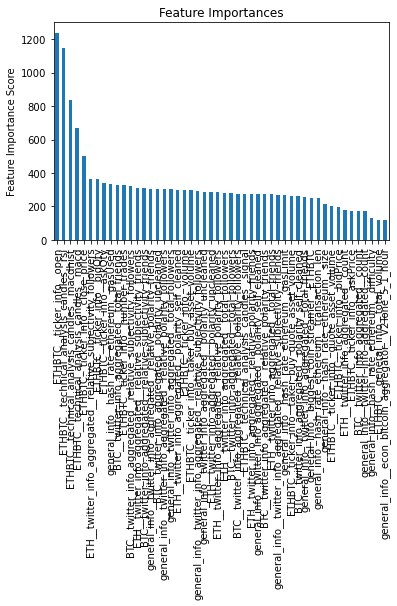

In [13]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

features = modelfit(xgb1, train, test, predictors,errortype='auc')


In [14]:
winsound.Beep(1000, 3000)

In [15]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    n_estimators=140, 
    max_depth=5,
    min_child_weight=1, 
    gamma=0, 
    subsample=0.8, 
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=1, 
    seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

C:\Users\lexfo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=0.8, tree_meth

In [16]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([30.00428391, 30.82963428, 30.88428411, 50.92150455, 47.82048464,
         48.08372416, 72.71992664, 68.69026232, 69.83390212, 92.82941251,
         94.55858526, 81.02287679]),
  'std_fit_time': array([ 2.93246301,  2.21229173,  1.49426918,  6.56512413,  1.81638437,
          1.66079234, 11.68786147,  5.28463323, 11.04718979,  7.09608857,
         20.07726752,  5.51520536]),
  'mean_score_time': array([0.15754323, 0.15994549, 0.16615114, 0.17075524, 0.15353966,
         0.15253868, 0.17676077, 0.1615468 , 0.16555057, 0.19217482,
         0.18697004, 0.14192924]),
  'std_score_time': array([0.01590899, 0.02330568, 0.02977955, 0.02140754, 0.0222338 ,
         0.00983947, 0.04360394, 0.00973713, 0.0089659 , 0.0459504 ,
         0.01758199, 0.02360457]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         f

In [17]:
winsound.Beep(1000, 3000)

In [19]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, 
                                                  n_estimators=140, 
                                                  max_depth=5,
                                                  min_child_weight=2, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_,gsearch2.best_score_

C:\Users\lexfo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([31.32626209, 32.01944437, 30.7071229 , 33.1475421 , 40.35829916,
         39.55997305, 41.33638859, 41.0429215 , 51.8661634 , 48.84741855,
         50.42325144, 45.34803662]),
  'std_fit_time': array([3.00451416, 4.72879892, 2.69001722, 4.50997434, 2.18737018,
         3.94363164, 6.40506032, 1.64416859, 6.53471305, 5.45964958,
         9.02709215, 3.96179714]),
  'mean_score_time': array([0.15714278, 0.1519381 , 0.14232936, 0.16054611, 0.15594192,
         0.15994534, 0.14893532, 0.17595987, 0.15494099, 0.15454049,
         0.15874448, 0.12991824]),
  'std_score_time': array([0.01610199, 0.01069436, 0.00898362, 0.01994394, 0.01531632,
         0.018751  , 0.01332968, 0.03529914, 0.00987621, 0.01287402,
         0.01575723, 0.02140522]),
  'param_max_depth': masked_array(data=[3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [20]:
winsound.Beep(1000, 3000)

In [22]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=140, 
                                                  max_depth=3,
                                                  min_child_weight=6, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
print(gsearch3.cv_results_, gsearch3.best_score_)

print('------------------------')
gsearch3.best_params_

C:\Users\lexfo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


------------------------


0.7613043298941025

In [23]:
winsound.Beep(1000, 3000)


Model Report
Accuracy : 0.8404
auc Score (Train): 0.924216
auc Score (Test): 0.803767


(ETHBTC__technical_analysis_candles__rsi                          582
 ETHBTC__technical_analysis_candles__macdhist                     444
 ETHBTC__ticker_info__open                                        420
 ETHBTC__technical_analysis_candles__macd                         388
 ETHBTC__ticker_info__close_price                                 148
 ETHBTC__ticker_info__number_trades                               103
 ETHBTC__ticker_info__taker_buy_asset_volume                       92
 ETHBTC__ticker_info__volume                                       91
 ETHBTC__ticker_info__quote_asset_volume                           89
 ETHBTC__ticker_info__taker_buy_quote_asset_volume                 88
 ETHBTC__technical_analysis_candles__signal                        84
 ETHBTC__ticker_info__bidQty                                       80
 ETHBTC__ticker_info__askQty                                       74
 general_info__hash_rate_ethereum__gasUsed                         70
 ETHBTC__ticker_info

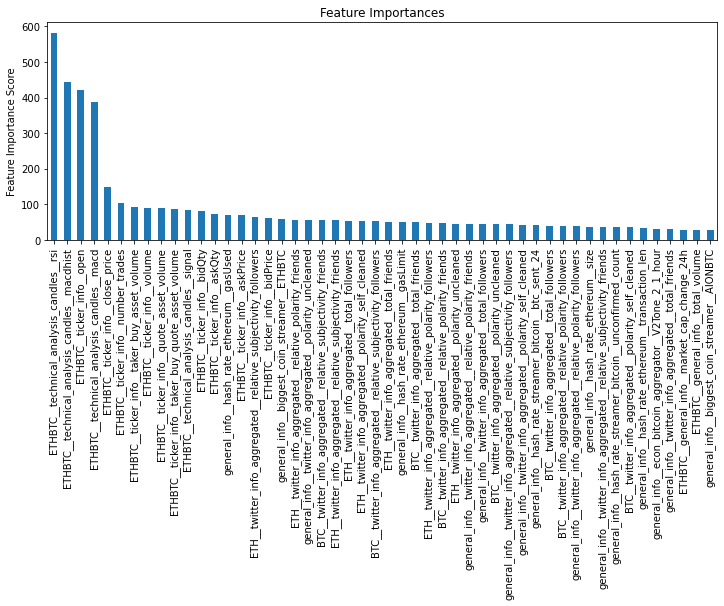

In [26]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
                learning_rate =0.1,
                n_estimators=1000,
                max_depth=3,
                min_child_weight=6,
                gamma=0.3,
                subsample=0.8,
                colsample_bytree=0.8,
                objective= 'binary:logistic',
                nthread=4,
                scale_pos_weight=1,
                seed=27)
modelfit(xgb2, train,test, predictors)

In [27]:
winsound.Beep(1000, 3000)

In [28]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=177, 
                                                  max_depth=3,
                                                  min_child_weight=6, 
                                                  gamma=0.3, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
print(gsearch4.cv_results_, gsearch4.best_score_)

print('------------------------')
gsearch4.best_params_

C:\Users\lexfo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([28.03654361, 30.29444757, 32.14076734, 31.38624201, 32.32779112,
       33.16086168, 34.62656155, 35.44661584, 37.41498852, 38.90027571,
       39.48350363, 40.22838106, 39.7714355 , 41.60160227, 44.40206509,
       39.97623258]), 'std_fit_time': array([2.86984052, 3.04760299, 3.11241161, 3.08112519, 3.59928914,
       2.54616419, 0.86803636, 2.76839008, 3.59324631, 3.92066728,
       5.88024538, 5.36571218, 1.36965698, 3.00409514, 3.50106858,
       7.87511514]), 'mean_score_time': array([0.16006589, 0.15614176, 0.15173745, 0.17515931, 0.1515378 ,
       0.15193887, 0.1673522 , 0.17736125, 0.14433136, 0.16094623,
       0.16635137, 0.16014566, 0.16195736, 0.17215657, 0.15230274,
       0.13422232]), 'std_score_time': array([0.02077879, 0.0151662 , 0.01454047, 0.02422934, 0.0156167 ,
       0.02781255, 0.04843556, 0.04483995, 0.011628  , 0.02204189,
       0.01650005, 0.01684373, 0.0129821 , 0.01949055, 0.01000609,
       0.03321258]), 'param_colsample_bytree':

{'colsample_bytree': 0.8, 'subsample': 0.6}

In [29]:
winsound.Beep(1000, 3000)

In [32]:
param_test5 = {
    'colsample_bytree':[i/100.0 for i in range(70,85,5)],
    'subsample':[i/100.0 for i in range(50,65,5)]
 
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,
                                                  n_estimators=177,
                                                  max_depth=3,
                                                  min_child_weight=6,
                                                  gamma=0.3, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
print(gsearch5.cv_results_, gsearch5.best_score_)

print('------------------------')
gsearch5.best_params_

C:\Users\lexfo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([30.77401013, 32.06553249, 31.8746419 , 34.39567161, 33.74115458,
       33.65417309, 35.47715368, 35.41373153, 31.13788819]), 'std_fit_time': array([2.2043377 , 3.39419642, 3.64797932, 4.07124706, 3.44669767,
       2.08691932, 1.42661083, 2.88487636, 5.06390728]), 'mean_score_time': array([0.14132853, 0.15474072, 0.14845552, 0.15754342, 0.14833503,
       0.14540896, 0.16505404, 0.1423296 , 0.12937832]), 'std_score_time': array([0.00731163, 0.01827698, 0.01205518, 0.01412087, 0.01302582,
       0.01256883, 0.02775752, 0.00778922, 0.02627821]), 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.75, 0.75, 0.75, 0.8, 0.8, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.5, 0.55, 0.6, 0.5, 0.55, 0.6, 0.5, 0.55, 0.6],
             mask=[False, False, False, False, False, False, False, False,
                

{'colsample_bytree': 0.7, 'subsample': 0.5}

In [33]:
winsound.Beep(1000, 3000)

In [35]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=177, 
                                                  max_depth=3,
                                                  min_child_weight=6, 
                                                  gamma=0.3, 
                                                  subsample=0.5, 
                                                  colsample_bytree=0.7,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
print(gsearch6.cv_results_, gsearch6.best_score_)
print('------------------------')
gsearch6.best_params_

C:\Users\lexfo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([31.44686508, 30.99709229, 31.04557714, 32.82780404, 27.4253685 ]), 'std_fit_time': array([1.3077268 , 1.25933667, 3.97131195, 3.04460238, 4.14263749]), 'mean_score_time': array([0.15479531, 0.1488358 , 0.16204805, 0.15544658, 0.12676601]), 'std_score_time': array([0.02570573, 0.00997695, 0.02164451, 0.00949293, 0.02562265]), 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 1e-05}, {'reg_alpha': 0.01}, {'reg_alpha': 0.1}, {'reg_alpha': 1}, {'reg_alpha': 100}], 'split0_test_score': array([0.80560133, 0.80596117, 0.80851867, 0.8033133 , 0.80515168]), 'split1_test_score': array([0.70684904, 0.70688723, 0.70368263, 0.70587961, 0.81739037]), 'split2_test_score': array([0.71416842, 0.7140802 , 0.7152932 , 0.71775963, 0.81453794]), 'split3_test_score': array([0.8047894 , 0.80589649, 0.80476613, 0.80712356, 0.82328038]), 'spli

{'reg_alpha': 100}

In [36]:
winsound.Beep(1000, 3000)

In [ ]:
param_test7 = {
 'reg_alpha':[0.1, 0.5, 1, 5, 10, 25]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
winsound.Beep(1000, 3000)

In [ ]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=2,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.75,
 reg_alpha=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, test, predictors)

In [ ]:
winsound.Beep(1000, 3000)

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=2,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.75,
 reg_alpha=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
features = modelfit(xgb4, train, test, predictors)

In [37]:
def write_as_log(title,data):
    '''
    Function can be used to write a log in the logs folder. 
    Data has to be an array 
    '''
    with open(f'logs/log_lex/ETHBTC/{title}.txt','w') as temp:
        if type(data) == list:
            for row in data:
                temp.write(str(row))
                temp.write('\n')

In [38]:
features_XGboost = list(features.index)

TypeError: 'builtin_function_or_method' object is not iterable

In [ ]:
write_as_log('results_XGBoost_AUC_345', features_XGboost)

In [ ]:
winsound.Beep(1000, 3000)

<h1> Method 4: GA

In [ ]:
#http://www.philipkalinda.com/ds8.html
#https://dkopczyk.quantee.co.uk/genetic-algorithm/
    
import random
import numpy as np
import matplotlib.pyplot as plt


SEED = 2018
random.seed(SEED)
np.random.seed(SEED)

# #==============================================================================
# # Data 
# #==============================================================================
# #dataset = load_boston()
# #X, y = dataset.data, dataset.target
# features = final_columns

# #==============================================================================
# # CV MSE before feature selection
# #==============================================================================
# score = -1 * cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
# print("CV MSE before feature selection: {:.2f}".format(np.mean(score)))


# #==============================================================================
# # Class performing feature selection with genetic algorithm
# #==============================================================================
class GeneticSelector():
    def __init__(self, estimator, n_gen, size, n_best, n_rand, 
                 n_children, mutation_rate):
        # Estimator 
        self.estimator = estimator
        # Number of generations
        self.n_gen = n_gen
        # Number of chromosomes in population
        self.size = size
        # Number of best chromosomes to select
        self.n_best = n_best
        # Number of random chromosomes to select
        self.n_rand = n_rand
        # Number of children created during crossover
        self.n_children = n_children
        # Probablity of chromosome mutation
        self.mutation_rate = mutation_rate 
        
        if int((self.n_best + self.n_rand) / 2) * self.n_children != self.size:
            raise ValueError("The population size is not stable.")  
            
    def initilize(self):
        population = []
        for i in range(self.size):
            chromosome = np.ones(self.n_features, dtype=np.bool)
            mask = np.random.rand(len(chromosome)) < 0.3
            chromosome[mask] = False
            population.append(chromosome)
        return population

    def fitness(self, population):
        X, y = self.dataset
        scores = []
        for chromosome in population:
            score = -1.0 * np.mean(cross_val_score(self.estimator, X[:,chromosome], y, 
                                                       cv=5, 
                                                       scoring=settings['scoring_type']))
            if score == 0: #since *-1 does not work for 0 
                score = 1
            scores.append(score)
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds]), list(population[inds,:])

    def select(self, population_sorted):
        population_next = []
        for i in range(self.n_best):
            population_next.append(population_sorted[i])
        for i in range(self.n_rand):
            population_next.append(random.choice(population_sorted))
        random.shuffle(population_next)
        return population_next

    def crossover(self, population):
        population_next = []
        for i in range(int(len(population)/2)):
            for j in range(self.n_children):
                chromosome1, chromosome2 = population[i], population[len(population)-1-i]
                child = chromosome1
                mask = np.random.rand(len(child)) > 0.5
                child[mask] = chromosome2[mask]
                population_next.append(child)
        return population_next

    def mutate(self, population):
        population_next = []
        for i in range(len(population)):
            chromosome = population[i]
            if random.random() < self.mutation_rate:
                mask = np.random.rand(len(chromosome)) < 0.05
                chromosome[mask] = False
            population_next.append(chromosome)
        return population_next

    def generate(self, population):
        # Selection, crossover and mutation
        scores_sorted, population_sorted = self.fitness(population)
        population = self.select(population_sorted)
        population = self.crossover(population)
        population = self.mutate(population)
        # History
        self.chromosomes_best.append(population_sorted[0])
        self.scores_best.append(scores_sorted[0])
        self.scores_avg.append(np.mean(scores_sorted))
        
        return population

    def fit(self, X, y):
 
        self.chromosomes_best = []
        self.scores_best, self.scores_avg  = [], []
        
        self.dataset = X, y
        self.n_features = X.shape[1]
        
        population = self.initilize()
        for i in range(self.n_gen):
            population = self.generate(population)
            
        return self 
    
    @property
    def support_(self):
        return self.chromosomes_best[-1]

    def plot_scores(self):
        plt.plot(self.scores_best, label='Best')
        plt.plot(self.scores_avg, label='Average')
        plt.legend()
        plt.ylabel('Scores')
        plt.xlabel('Generation')
        plt.show()
        
        



In [ ]:
#def extract_info():
df_scores = pd.DataFrame(index=final_columns)
data = Datahandling('scores_ga_columns.csv')
highest_iter = data.highest_iteration
df_models_scores = data.current_df
if 'ga' in settings['wrapper_tech'].keys():
    t1 = time.time()
    for type_model in settings['models'].keys():
        t2 = time.time()
        if 'svm' ==type_model:
            model = SVR(**settings['models']['svm'])
            
            
        elif 'rf' ==type_model:
            model = RandomForestRegressor(**settings['models']['rf'])
            
        sel = GeneticSelector(estimator=model, 
                      n_gen=7, size=200, n_best=40, n_rand=40, 
                      n_children=5, mutation_rate=0.05)     
        sel.fit(X, y)
        score =  np.mean(-1*cross_val_score(model,
                                       X[:,sel.support_],
                                       y,
                                       cv=settings['cross_val_times'],
                                       scoring=settings['scoring_type']))
        scores = {column:{} for column in final_columns}
        for i in range(len(final_columns)):
            scores[final_columns[i]] = {
                f"selected_{type_model}":sel.support_[i]}
                #f"ranking_{type_model}":rfecv.ranking_[i]} #selected features are always 1 
               # "grid_score":rfecv.grid_scores_[i],The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.
                #"estimator":rfecv.estimator_[i]
        summary = [{
            'wrapper':type_model,
            'iteration':highest_iter +1,
            #'grid_scores': rfecv.grid_scores_,
            'optimal_number_of_features':len([x for x in sel.support_ if x]), #only true
            'scores':scores,

            'score_optimal_features':score,
            'scoring_type':settings['scoring_type'],
            "cross_val_times":settings['cross_val_times'],
            "datapoints":settings['datapoints'],
            'params':settings['models'][type_model],
            'running_time':time.time() - t2
        }
        ]

        
        df_models_scores = df_models_scores.append(summary,ignore_index=True)
        #df_new = pd.DataFrame.from_dict(scores,orient='index')
        #df_scores = df_scores.merge(df_new,left_index=True,right_index=True)
        #df_models_scores = df_models_scores.append(summary,ignore_index=True)
data.save_after_iter(df_models_scores)
print(f"total running time: {time.time() - t1}")
        
        
    

    